# Sign Language MNIST

In [1]:
import os
import math

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import keras
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, Rescaling, Flatten
from keras.utils import image_dataset_from_directory
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
import sklearn.preprocessing as preprocessing
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

2022-11-11 20:54:29.245707: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# CONSTANTS

In [3]:
WIDTH = 28
HEIGHT = 28
CHANNELS = 1
INPUT_SHAPE = (WIDTH, HEIGHT, CHANNELS)
CSV_FILE_TRAIN = '/mnt/files/Datasets/sign-language-mnist/sign_mnist_train.csv'
CSV_FILE_TEST = '/mnt/files/Datasets/sign-language-mnist/sign_mnist_test.csv'
BATCH_SIZE = 256
LR_INITIAL = 0.0001
N_EPOCHS = 40

# DATASET

In [4]:
df_train_raw = pd.read_csv(CSV_FILE_TRAIN, sep=',')
df_test_raw = pd.read_csv(CSV_FILE_TEST, sep=',')

In [5]:
df_train_raw.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [6]:
df_test_raw.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [7]:
df_train_raw['label'].value_counts()

17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
3     1196
14    1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: label, dtype: int64

In [8]:
df_test_raw['label'].value_counts()

4     498
7     436
1     432
12    394
6     348
15    347
21    346
24    332
0     331
10    331
2     310
13    291
8     288
23    267
20    266
19    248
5     247
14    246
18    246
3     245
11    209
22    206
16    164
17    144
Name: label, dtype: int64

In [9]:
# decreasing 1 for x > 9 because the dataset jump the label 9
df_train_raw['label'] = df_train_raw["label"].apply(lambda x: x - 1 if x > 9 else x)
df_test_raw['label'] = df_test_raw["label"].apply(lambda x: x - 1 if x > 9 else x)

In [10]:
df_train_raw['label'].min(), df_train_raw['label'].max()

(0, 23)

In [11]:
df_test_raw['label'].min(), df_test_raw['label'].max()

(0, 23)

In [12]:
size_train = len(df_train_raw)
size_test = len(df_test_raw)
print(f"Size of train: {size_train} | Size of test: {size_test}")

Size of train: 27455 | Size of test: 7172


In [13]:
# Checking if there are some NaN values
assert df_train_raw.isna().sum().to_numpy().sum() == df_train_raw.isna().sum().sum() == 0

In [14]:
# Separating the label from the features
y = df_train_raw.pop('label')
y_test = df_test_raw.pop('label')
X = df_train_raw.copy()
X_test = df_test_raw.copy()

In [15]:
# Splitting train set into two (train + valid)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [16]:
# Transforming in tensor
X_train = tf.convert_to_tensor(value=X_train)
y_train = tf.convert_to_tensor(value=y_train)
X_val = tf.convert_to_tensor(value=X_val)
y_val = tf.convert_to_tensor(value=y_val)
X_test = tf.convert_to_tensor(value=X_test)
y_test = tf.convert_to_tensor(value=y_test)

In [17]:
# PIXELS
X_train = tf.reshape(X_train, shape=[-1, 28, 28])
X_train = tf.expand_dims(X_train, axis=3)
X_val = tf.reshape(X_val, shape=[-1, 28, 28])
X_val = tf.expand_dims(X_val, axis=3)
X_test = tf.reshape(X_test, shape=[-1, 28, 28])
X_test = tf.expand_dims(X_test, axis=3)

In [18]:
print(f"Train: {X_train.shape, y_train.shape}")
print(f"Val: {X_val.shape, y_val.shape}")
print(f"Test: {X_test.shape, y_test.shape}")

Train: (TensorShape([24709, 28, 28, 1]), TensorShape([24709]))
Val: (TensorShape([2746, 28, 28, 1]), TensorShape([2746]))
Test: (TensorShape([7172, 28, 28, 1]), TensorShape([7172]))


## Some Examples

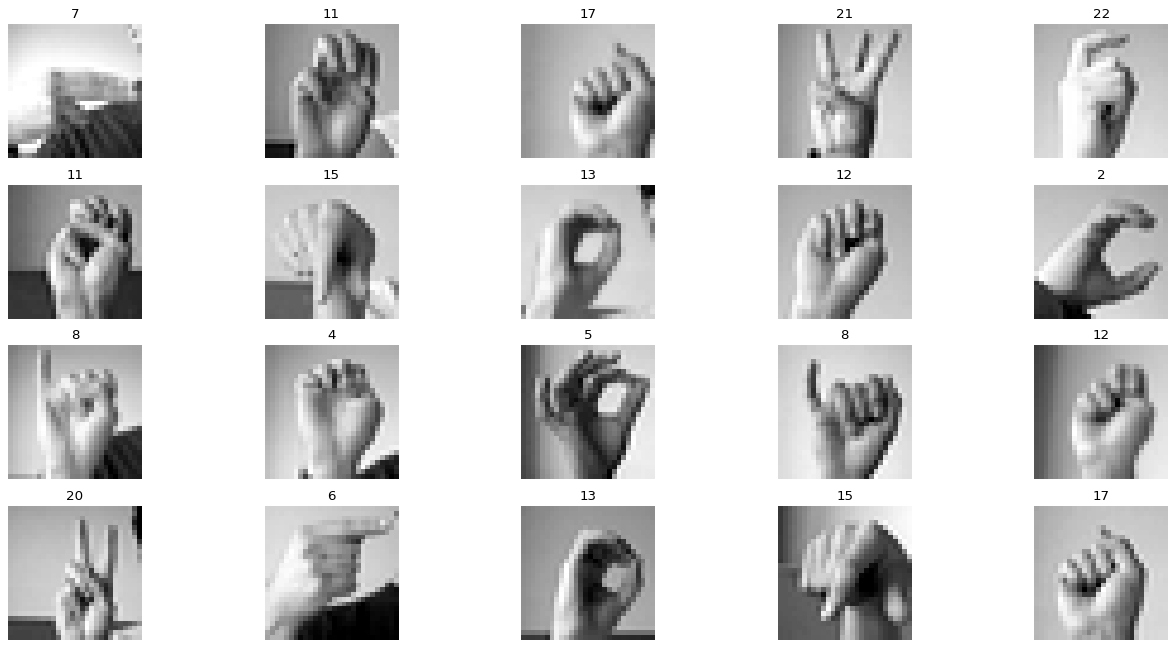

In [19]:
figure(figsize=(20, 10), dpi=80)
for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    ax.imshow(X_train[i], cmap='gray')
    ax.axis('off')
    ax.set_title(y_train[i].numpy().astype('uint8'))

# MODEL

In [20]:
input_layer = Input(shape=(28, 28, 1))
x = Rescaling(1./255, offset=0.0)(input_layer)
x = Conv2D(filters=32,
           kernel_size=(5, 5),
           strides=(1, 1),
           padding='same',
           activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=32,
           kernel_size=(3, 3),
           strides=(1, 1),
           padding='same',
           activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64,
           kernel_size=(3, 3),
           strides=(1, 1),
           padding='same',
           activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64,
           kernel_size=(3, 3),
           strides=(1, 1),
           padding='same',
           activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(units=24, activation='softmax')(x)
model = keras.Model(inputs=input_layer, outputs=x)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                             

# CALLBACKS

In [22]:
checkpoint_filepath = '/tmp/checkpoint/best_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

callbacks = [model_checkpoint_callback]

# OPTIMIZER

In [23]:
optimizer = SGD(learning_rate=LR_INITIAL, momentum=0.9)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# COMPILE

In [24]:
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# TRAINING

In [25]:
history = model.fit(x=X_train, 
                    y=y_train,
                    validation_data=(X_val, y_val),
                    epochs=N_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=callbacks, verbose=1)

Epoch 1/40
97/97 [==============================] - 10s 21ms/step - loss: 4.0556 - accuracy: 0.1188 - val_loss: 3.2956 - val_accuracy: 0.0401
Epoch 2/40
97/97 [==============================] - 2s 16ms/step - loss: 2.6849 - accuracy: 0.2610 - val_loss: 3.3692 - val_accuracy: 0.0590
Epoch 3/40
97/97 [==============================] - 2s 19ms/step - loss: 2.1127 - accuracy: 0.3749 - val_loss: 3.1677 - val_accuracy: 0.0637
Epoch 4/40
97/97 [==============================] - 2s 19ms/step - loss: 1.7446 - accuracy: 0.4679 - val_loss: 2.4770 - val_accuracy: 0.2338
Epoch 5/40
97/97 [==============================] - 2s 19ms/step - loss: 1.4379 - accuracy: 0.5532 - val_loss: 1.6341 - val_accuracy: 0.5484
Epoch 6/40
97/97 [==============================] - 2s 19ms/step - loss: 1.2184 - accuracy: 0.6190 - val_loss: 0.9954 - val_accuracy: 0.7560
Epoch 7/40
97/97 [==============================] - 2s 19ms/step - loss: 1.0431 - accuracy: 0.6710 - val_loss: 0.6766 - val_accuracy: 0.8602
Epoch 8/40
9

# EVALUATING

In [26]:
#model.load_weights('/tmp/checkpoint/best_model.h5')  # Loading the best model

In [27]:
out = model.evaluate(X_test, y_test)

225/225 [==============================] - 1s 3ms/step - loss: 0.3279 - accuracy: 0.9030


In [28]:
loss, acc = out[0], out[1]
print(f"loss = {loss:.4f} | acc = {acc:.4f}")

loss = 0.3279 | acc = 0.9030


## Curves

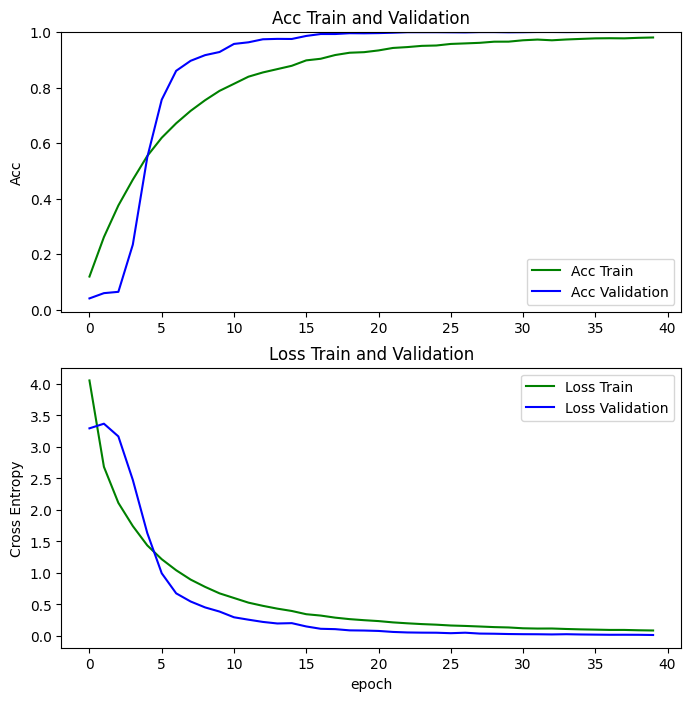

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, 'g', label='Acc Train')
plt.plot(val_acc, 'b', label='Acc Validation')
plt.legend(loc='lower right')
plt.ylabel('Acc')
plt.ylim([min(plt.ylim()),1.001])
plt.title('Acc Train and Validation')

plt.subplot(2, 1, 2)
plt.plot(loss, 'g', label='Loss Train')
plt.plot(val_loss, 'b', label='Loss Validation')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Loss Train and Validation')
plt.xlabel('epoch')
plt.show()